<a href="https://colab.research.google.com/github/angiekim05/study/blob/master/Paper_Code_Practice/Transformer/Attention_is_All_You_Need_(Transformer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention is All You Need 코드 구현해보기

2022년 12월 기준
- torchtext 0.14.0 버전
- 참고 자료
  - 논문: [Attension Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)
  - 전처리: [nkw011님의 블로그](https://velog.io/@nkw011/nlp-dataset-dataloader)
  - 모델: [hyunwoongko님의 깃허브](https://github.com/hyunwoongko/transformer)
  - 모델: [devsaka님의 블로그](https://catsirup.github.io/ai/2020/04/09/transformer-code.html)

## 1. 데이터 전처리
- 모델 구현 전, 모델 학습에 사용될 데이터 준비
- http://www.manythings.org/anki/ 에서 제공하는 한국어-영어 데이터셋 활용

### 1) 데이터셋 불러오기

In [ ]:
!wget http://www.manythings.org/anki/kor-eng.zip -O kor-eng.zip
!unzip kor-eng.zip

--2022-12-12 01:48:08--  http://www.manythings.org/anki/kor-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153571 (150K) [application/zip]
Saving to: ‘kor-eng.zip’

kor-eng.zip         100%[===================>] 149.97K  --.-KB/s    in 0.1s    

2022-12-12 01:48:08 (1.05 MB/s) - ‘kor-eng.zip’ saved [153571/153571]

Archive:  kor-eng.zip
  inflating: _about.txt              
  inflating: kor.txt                 


- 데이터셋 확인
- 데이터 셔플을 통해 랜덤으로 섞어줌으로써 추후 train,valid,test 분리를 쉽게 함


In [ ]:
import pandas as pd
data = pd.read_csv('kor.txt', delimiter="\t", header=None, names = ['en', 'ko', 'cc'])
data = data.sample(frac=1, random_state=0).reset_index(drop=True)
data.tail(1)

,en,ko,cc
3852,Don't act like you're so innocent.,너 그렇게 순수한 척 하지 마.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...


### 2) 형태소 분석 / 토큰화
- 한국어 형태소 분석기 파이썬 패키지

In [ ]:
! pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 465 kB 52.5 MB/s 


- 한국어 형태소 분석 예시

In [ ]:
from konlpy.tag import Komoran
tokenizer = Komoran()
def tokenize_ko(text):
    return tokenizer.morphs(text)
text = data["ko"][1500]
tokenize_ko(text)

['톰', '은', '고양이', '를', '싫어하', '아', '.']

- 영어 형태소 분석 예시

In [ ]:
import spacy
spacy_en = spacy.load('en_core_web_sm')
def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]
text = data["en"][1500]
tokenize_en(text)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


['Tom', 'hates', 'cats', '.']

- 데이터가 많지 않음으로 데이터프레임에서 바로 토큰화
- 최소,최대 토큰의 길이도 확인
- max_seq_length = 111

In [ ]:
data['ko_token'] = data['ko'].apply(lambda row: tokenize_en(row))
data['en_token'] = data['en'].apply(lambda row: tokenize_en(row))
data['ko_cnt'] = data['ko_token'].apply(lambda row: len(row))
data['en_cnt'] = data['en_token'].apply(lambda row: len(row))
print("ko:",min(data['ko_cnt']),"~",max(data['ko_cnt']),", en:",min(data['en_cnt']),"~",max(data['en_cnt']))

ko: 2 ~ 95 , en: 2 ~ 111


### 3) 단어(토큰) 사전 구축
- torchtext.vocab.build_vocab_from_iterator 를 통해서 한글과 영어 단어 사전을 구축
- train data에 해당하는 단어들로만 구축
- 최소 2번 이상 등장한 단어만 사전으로 구축
  - min_freq = 2
- 사전에 special 토큰도 포함해줌
  - \<unk>: unknown token
  - \<sos>: start of sentence
  - \<eos>: end of sentence
  - \<pad>: padding

In [ ]:
from torchtext.vocab import build_vocab_from_iterator
vocab_ko = build_vocab_from_iterator(data['ko_token'][:3153],min_freq=1, specials=["<unk>", "<sos>", "<eos>", "<pad>"])
vocab_en = build_vocab_from_iterator(data['en_token'][:3153],min_freq=1, specials=["<unk>", "<sos>", "<eos>", "<pad>"])

- vocab.get_stoi() 단어를 숫자로 변환하는 사전 (string to int)
- vocab.get_itos() 숫자를 단어로 변환하는 사전 (int to string)

In [ ]:
ko_stoi = vocab_ko.vocab.get_stoi()
en_stoi = vocab_en.vocab.get_stoi()
ko_itos = vocab_ko.vocab.get_itos()
en_itos = vocab_en.vocab.get_itos()
print("ko voca 크기:",len(ko_stoi),"\nen voca 크기:",len(en_stoi))
print("specital 토큰:",{k:ko_stoi[k] for k in ["<unk>", "<sos>", "<eos>", "<pad>"]})
# print("specital 토큰:",{k:en_stoi[k] for k in ["<unk>", "<sos>", "<eos>", "<pad>"]})

ko voca 크기: 5092 
en voca 크기: 2574
specital 토큰: {'<unk>': 0, '<sos>': 1, '<eos>': 2, '<pad>': 3}


### 4) Token encoding / decoding
- 단어 사전을 통해 데이터셋의 단어들을 숫자로 변환
  - 시작토큰, 끝토큰, 패딩 추가

In [ ]:
def encode(data,stoi):
    unk_token = 0
    sos_token = 1
    eos_token = 2
    encoded = []
    for x in data:
        encoded.append(
            [sos_token]
            + [stoi.get(token,unk_token) for token in x]
            + [eos_token]
        )
    return encoded

# eos 토큰이 나오면 이후는 모두 pad 토큰일 것임으로 자름 (trim)
# itos 사전을 통해 숫자 -> 단어
def decode(data,itos):
    sos_token = 1
    eos_token = 2
    pad_token = 3
    def trim(sentence,eos_token):
        s = []
        for w in sentence:
            if w == eos_token:
                break
            s.append(w)
        return s
    data = [trim(x,eos_token) for x in data]
    data = [[itos[i] for i in x if i not in (sos_token,pad_token)] for x in data]
    return [' '.join(x)  for x in data]

In [ ]:
data_ko = encode(data['ko_token'],ko_stoi)
data_en = encode(data['en_token'],en_stoi)

### 5) Dataset 구성
- 현재 데이터가 3853개 임으로
  - train, valid, test = 3153, 350, 350 로 분리
  - train = 0 ~ 3153, valid = 3153 ~ 3503, test = 3503 ~ 3853

In [ ]:
train_data = [(data_ko[i],data_en[i]) for i in range(3153)]
valid_data = [(data_ko[i],data_en[i]) for i in range(3153,3503)]
test_data = [(data_ko[i],data_en[i]) for i in range(3503,3853)]

In [ ]:
class Dataset():
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        return self.dataset[idx]

In [ ]:
train_dataset = Dataset(train_data)

In [ ]:
train_dataset[0]

([1, 11, 45, 23, 231, 12, 1365, 554, 252, 4, 2],
 [1, 5, 194, 15, 5, 115, 50, 1104, 6, 95, 4, 2])

#### Collate function
- collate_fn: DataLoader를 구성할 때, 배치마다 최대 길이에 맞춰 padding을 넣어주는 함수
- torch에서 제공하는 pad_sequence 활용

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence

In [ ]:
def collate_fn(batch_samples):
    pad_token = 3

    src_sentences = pad_sequence([torch.tensor(src) for src, _ in batch_samples], batch_first=True, padding_value=pad_token)
    tgt_sentences = pad_sequence([torch.tensor(tgt) for _, tgt in batch_samples], batch_first=True, padding_value=pad_token)

    return src_sentences, tgt_sentences

#### Bucketing Sampler
- bucketing_sampler: DataLoader를 구성할 때, padding의 길이를 비슷하게 유지하기 위해서 seq의 길이가 유사한 데이터끼리 미리 묶어 놓는 함수 (이미 묶인 배치를 데이터로더를 통해 랜덤하게 학습)
- batch size만큼씩 데이터의 인덱스가 묶인 이중 리스트 형태로 반환됨
- 예를 들어 50개의 데이터가 있고 batch의 크기를 5로 지정한다면, batch_sampler 통해 (10*5) 모양의 이중 리스트를 반환하게 됨

![Buckting_sampler](https://sooftware.io/static/d35fd77fe1abce1948a61534ae0683af/4c98a/ulb.webp)

In [ ]:
import random

In [ ]:
class BucketingSampler():
    def __init__(self, ko_cnt, en_cnt, batch_size=1,random_seed=False):
        data_len = [(x, y, idx) for idx,(x, y) in enumerate(zip(ko_cnt,en_cnt))]
        data_len.sort()
        data_idx = [data[2] for data in data_len]
        self.bins = [data_idx[i:i+batch_size] for i in range(0,len(data_idx), batch_size)]
        # seed 설정
        if random_seed:
            random.seed(random_seed)
        # 모델이 batch 길이에 편향되지 않도록 섞음
        random.shuffle(self.bins) 

    def __iter__(self):
        for idx_set in self.bins:
            yield idx_set

In [ ]:
sampler = BucketingSampler(data['ko_cnt'][:3153],data['en_cnt'][:3153], batch_size = 8)

In [ ]:
for i in sampler:
    print(i)
    break

[1872, 1878, 1936, 1986, 1993, 2008, 2009, 2031]


### 6) DataLoader 생성

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_sampler=sampler,
    collate_fn=collate_fn,
)

In [ ]:
for ko,en in train_loader:
    print(ko)
    print(en)
    break

tensor([[   1,   13,   51, 3863, 2331,    4,    2],
        [   1,   10,  210, 3373,   54,    4,    2],
        [   1,   13, 2348, 3890, 3511,    4,    2],
        [   1,   11,   23, 4347,  166,    4,    2],
        [   1,   13, 3551,   13, 3531,    4,    2],
        [   1,    5, 2204, 3229, 3659,    4,    2],
        [   1,    8,  148, 1425, 1474,    4,    2],
        [   1, 1920,   29, 1075,  347,    6,    2]])
tensor([[   1,   58,   14,   17,   35, 1858,    4,    2],
        [   1,    5,  108,   32,    7,  399,    4,    2],
        [   1,   43, 1747,   19, 1016, 2511,    4,    2],
        [   1,    5,  194,    5,   92, 1287,    4,    2],
        [   1, 1412,  277,   18,   42, 1228,    4,    2],
        [   1,    6,  314,    7,   29, 2062,    4,    2],
        [   1,    5,  355,   13,  289,  184,    4,    2],
        [   1,  255,    9,  457,  128,   15,    8,    2]])


## 2. Attention
Scaled Dot-Product Attention은 Multi-Head Attention 에 포함된 부분

### 1) Scaled Dot-Product Attention

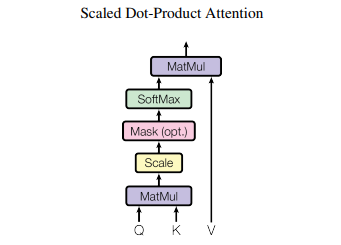

- dot-production(내적)이 사용되고, scale이 조정되기 때문에 이름이 붙여짐
- 여기서 MatMul이 각각의 행렬에 대하여 내적을 계산함
- scale 조절은 MatMul을 통과한 결과에 (K의 dimension($d_k$)에 루트 값을 취한 $\sqrt d_k$ 으로 나누어줌
- mask를 사용한다면 마스킹된 값을 음수(-1e10=-10,000,000,000)로 만들어줌
  - 논문에서는 setting to −∞ 라고 표현
- softmax를 통해 내적을 통해 커진 값을 축소함

$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt d_k})V$
- Q,K,V 는 [batch_size, head, seq_len, head_dim]
- 논문에서는 head$(h) = 8$, head_dim$(d_k=d_v) = 64$

##### 알고리즘 순서
1. $K$를 transpose하기
2. $Q$ 와 $K^T$ 의 MatMul
3. scale 곱하기
4. Mask가 있다면 해당 부위 $-1e10$으로 채우기
5. $softmax$ 취하기
  - 결과 값은 attention 결과 확인용으로 사용 가능 
  - [batch_size, head, seq_len, seq_len]
6. attention 결과값과 $V$ MatMul 계산하기

In [17]:
import torch
from torch import nn

In [18]:
class ScaleDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1) # dim = -1 은 단어들에 해당하는 위치 ([batch_size, head, seq_len, seq_len])
        
    def forward(self, q, k, v, mask=None):
        # q,k,v 의 크기는 같음 
        # [batch_size, head, seq_len, head_dim(기존 d_model을 head 수로 나눈 각 head의 dim)]
        batch_size, head, seq_len, head_dim = q.size()

        # 1. K를 transpose하기 (seq_len, head_dim의 위치 전환)
        k_t = k.transpose(-1,-2)

        # 2. Q 와 K^T 의 MatMul
        attention_score = torch.matmul(q,k_t)
        # attention_score: [batch_size, head, seq_len, seq_len]

        # 3. scale(1/sqrt(d_k == head_dim)) 곱하기
        attention_score /= torch.sqrt(torch.Tensor([head_dim]))

        # 4. Mask가 있다면 해당 부위 -1e10으로 채우기
        if mask:
            attention_score = attention_score.masked_fill(mask==0,-1e10) # Tensor.masked_fill_(mask_boolean, value)
        
        # 5. softmax 취하기 
        attention_score = self.softmax(attention_score)

        # 6. attention 결과값과 V MatMul 계산하기
        result = torch.matmul(attention_score, v)
        
        return result, attention_score

### 2) Multi-Head Attention

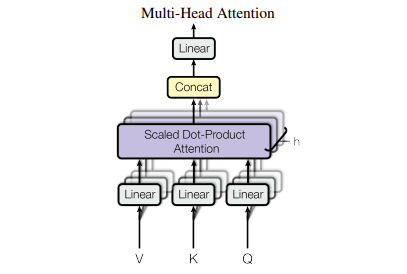

- key, value, query 단일 attention function을 쓰는 것보다 k,v,q를 각각 $d_k, d_k, d_v$ 차원으로 projection하여 $h$ 번 학습시키는 것
  - projection 한다는 것은 Linear Layer (fc layer)를 통과한다는 것 -> Weight
- 여기서 $h$ 번 학습은 key, value, query 를 $h$ 개로 나누어서 따로 병렬 학습하는 것을 말함
- 이후 $h$ 쌍의 head는 다시 합쳐지고(Concat) $d_{model}$ 차원으로 projection 됨

$MultiHead (Q, K, V) = Concat(head_1, ..., head_h)W^O,$

$where$  $head_i = Attention(QW^Q_i, KW^K_i, VW^V_i)$
- Q,K,V 는 [batch_size, seq_len, d_model]
- 논문에서는 $d_{model} = 512,  h = 8,  dk = dv = d_{model}/h = 64$ 을 사용함

##### 알고리즘 순서
1. $Q,K,V$를  $d_k, d_k, d_v$ 차원으로 projection
2. $Q,K,V$를 head 수 만큼 분리해주기
3. Scaled Dot-Product Attention 을 수행하기
4. 분리된 head들을 concat 하기
5. $d_{model}$ 차원으로 projection

In [ ]:
import torch
from torch import nn

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,head):
        super().__init__()
        self.d_model = d_model
        self.head = head
        self.head_dim = d_model // head
        self.w_q = nn.Linear(d_model,d_model)
        self.w_k = nn.Linear(d_model,d_model)
        self.w_v = nn.Linear(d_model,d_model)
        self.w_o = nn.Linear(d_model,d_model)
        self.attention = ScaleDotProductAttention()

    def forward(self, q, k, v, mask=None):
        #  [batch_size, seq_len, d_model]
        batch_size, seq_len, d_model = q.size()

        # 1. Q,K,V를  d_k, d_k, d_v 차원으로 projection
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. Q,K,V를 head 수 만큼 분리해주기 -> [batch_size, head, seq_len, head_dim]
        q = torch.cat(q.chunk(self.head, dim=-1), dim=0)
        k = torch.cat(k.chunk(self.head, dim=-1), dim=0)
        v = torch.cat(v.chunk(self.head, dim=-1), dim=0)

        # 3. Scaled Dot-Product Attention 을 수행하기
        out, attention_score = self.attention(q,k,v,mask)

        # 4. 분리된 head들을 concat 하기
        out = torch.cat(out.chunk(self.head,dim=0),dim=-1)

        # 5. d_model 차원으로 projection
        out = self.w_o(out)

        return out, attention_score

## 3. Position-wise Fully Connected Feed-Forward Network


$FFN(x) = max(0, xW_1+b_1)W_2 + b_2$
- 논문에서 $d_{model}=512, d_{ff} = 2048$을 사용
- 여기서 $max(0,X)$는 ReLU 활성함수 사용을 의미
- xW+b는 Linear Layer (fc layer)를 통과하는 것을 의미


##### 알고리즘 순서
1. x의 Linear Layer1 통과
2. ReLU 적용
3. Linear Layer2 통과

In [1]:
from torch import nn

In [2]:
class PositionWiseFCFeedForwardNetwork(nn.Module):
    def __init__(self,d_model,d_ff):
        super().__init__()
        self.w_1 = nn.Linear(d_model,d_ff)
        self.w_2 = nn.Linear(d_ff,d_model)
    
    def forward(self, x):
        # Linear Layer1
        x = self.w_1(x)

        # ReLU
        x = nn.ReLU(x)
        
        # Linear Layer2
        x = self.w_2(x)

        return x

## 4. Positional Encoding
- 문자 시퀀스의 위치 정보를 알려주는 역할


$PE_{(pos,2i)} = sin(pos/10000^{2i/d_{model}})$   
$PE_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}})$
- $pos$는 위치이고 $i$는 $d_{model}$차원을 뜻함

In [1]:
import torch
from torch import nn

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()

        # self.P_E는 [max_len,d_model]로 초기화 -> 입력 seq 길이에 따라 잘라서 사용 
        # (여러번 생성할 필요 없음)
        self.P_E = torch.zeros(max_len,d_model)
    
        # 문자 시퀀스의 위치 순서 (row => 2d)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(dim=1)

        # d_model 차원을 채울 i 값 (col)
        # 2i는 step = 2 를 활용하여 i의 2배수를 만듦
        _2i = torch.arange(0, d_model, step= 2, dtype=torch.float)

        # 제안된 positional encoding 생성
        self.P_E[:, 0::2] = torch.sin(pos / 10000 ** (_2i / d_model))
        self.P_E[:, 1::2] = torch.cos(pos / 10000 ** (_2i / d_model))

    def forward(self,x):
        # x seq 길이에 맞춰 PE 크기 조절
        batch_size, seq_len = x.size()
        PE_for_x = self.P_E[:seq_len,:]

        return PE_for_x

## 5. Encoder Layer

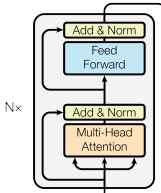


##### 알고리즘 순서
1. multi-head attention
2. add & norm
  - residual connection을 적용하여 multi-head attention을 들어가지 않은 x와 통과한 out을 더해주는 것
  - 이때 attention을 빠져나온 output에 dropout 적용
  - norm 은 layer normalization 을 의미
3. position-wise fc feed-forward network
4. add & norm

In [ ]:
from torch import nn

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, head, d_ff, dropout):
        super().__init()
        self.attention = MultiHeadAttention(d_model,head)
        self.layerNorm1 = nn.LayerNorm(d_model)

        self.ffn = PositionWiseFCFeedForwardNetwork(d_model,d_ff)
        self.layerNorm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # 1. multi-head attention
        residual = x  # residual connection을 위해 잠시 담아둠
        x, attention_score = self.attention(q=x, k=x, v=x, mask=mask)

        # 2. add & norm
        x = self.dropout(x) + residual
        x = self.layerNorm1(x)
        
        # 3. position-wise fc feed-forward network
        residual = x
        x = self.ffn(x)

        # 5. add & norm
        x = self.dropout(x) + residual
        x = self.layerNorm2(x)

        return x, attention_score

## 6. Encoder

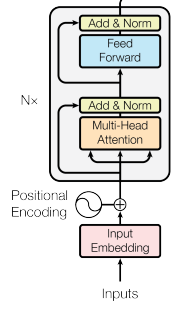

##### 알고리즘 순서
1. input embedding 생성
2. positional encoding 과 더하기
3. n 번 EncoderLayer 반복하기

In [2]:
import torch
from torch import nn

## 7. Decoder Layer

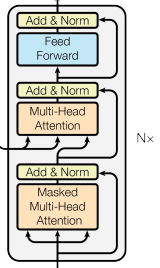

##### 알고리즘 순서
1. masked multi-head attention
2. add & norm
3. multi-head attention
4. add & norm
5. position-wise fc feed-forward network
6. add & norm

기타 참고

In [ ]:
# torch 에서 데이터를 나누는 방법
import torch
x = torch.rand(1,2,3,12)
# 1. split : n 개씩 그룹핑 하는 방법
y = x.split(4,dim=-1)
print("split")
for s in y:
    print(s.size())
# 2. chunk : n 개의 그룹으로 나누는 방법
z = x.chunk(4, dim=-1)
print("chunk")
for c in z:
    print(c.size())

split
torch.Size([1, 2, 3, 4])
torch.Size([1, 2, 3, 4])
torch.Size([1, 2, 3, 4])
chunk
torch.Size([1, 2, 3, 3])
torch.Size([1, 2, 3, 3])
torch.Size([1, 2, 3, 3])
torch.Size([1, 2, 3, 3])


In [ ]:
# torch sqrt가 가장 빠름
! python -mtimeit -s"import math;import torch; x = 123" "x**.5"
! python -mtimeit -s"import math; import torch; x = 123" "math.sqrt(x)"
! python -mtimeit -s"import math;import torch; x = 123" "torch.sqrt(torch.LongTensor([x]))"

2000000 loops, best of 5: 141 nsec per loop
5000000 loops, best of 5: 76.2 nsec per loop
50000 loops, best of 5: 8.65 usec per loop


In [ ]:
# view vs transpose vs permute 
import torch
x = torch.rand(1, 2, 3, 4)
# view는 shape을 바꿀때 사용
v = x.view(4, 6) # 주어진 shape에 맞게 x를 순서대로 나열
# transpose와 permute는 같은 역할
y = x.transpose(2,3)  # 자리를 바꿀 두가지 위치만
z = x.permute(0, 1, 3, 2) # 여러개를 동시에 위치를 바꿀 수 있음
print("x:",x)
print("view:",v)
print("y==z:",y)
print("y_size:",y.size())
print("z_size:",z.size())

x: tensor([[[[0.8530, 0.3703, 0.7778, 0.3644],
          [0.9095, 0.8721, 0.9329, 0.0492],
          [0.3753, 0.9459, 0.1605, 0.2636]],

         [[0.1008, 0.5555, 0.9933, 0.2101],
          [0.0928, 0.5636, 0.2046, 0.9553],
          [0.1892, 0.1911, 0.0958, 0.1915]]]])
view: tensor([[0.8530, 0.3703, 0.7778, 0.3644, 0.9095, 0.8721],
        [0.9329, 0.0492, 0.3753, 0.9459, 0.1605, 0.2636],
        [0.1008, 0.5555, 0.9933, 0.2101, 0.0928, 0.5636],
        [0.2046, 0.9553, 0.1892, 0.1911, 0.0958, 0.1915]])
y==z: tensor([[[[0.8530, 0.9095, 0.3753],
          [0.3703, 0.8721, 0.9459],
          [0.7778, 0.9329, 0.1605],
          [0.3644, 0.0492, 0.2636]],

         [[0.1008, 0.0928, 0.1892],
          [0.5555, 0.5636, 0.1911],
          [0.9933, 0.2046, 0.0958],
          [0.2101, 0.9553, 0.1915]]]])
y_size: torch.Size([1, 2, 4, 3])
z_size: torch.Size([1, 2, 4, 3])


In [ ]:
import torch
x = torch.rand(1, 3, 4)
print(x)
# view는 shape을 바꿀때 사용
v = x.view(1,2,3,2)
print(v)
w = x.view(1,3,2,2).transpose(1,2).contiguous()
print(w)
m = torch.cat(x.chunk(2, dim=-1),dim=0)
print(m)
y = w.transpose(1,2).contiguous().view(1,3,4)
print(y)
z = torch.cat(m.chunk(2,dim=0),dim=-1)
print(z)
print(v.is_contiguous(),w.is_contiguous(),m.is_contiguous(),z.is_contiguous(),z.is_contiguous())

In [36]:
# 속도비교
! python -mtimeit -s"import torch; x = torch.rand(500,3, 4)" "m = torch.cat(x.chunk(2, dim=-1),dim=0);w = x.view(500,3,2,2).transpose(1,2).contiguous();x.view(500,3,2,2).transpose(1,2)"
! python -mtimeit -s"import torch; x = torch.rand(500,3, 4)" "m = torch.cat(x.chunk(2, dim=-1),dim=0);w = x.view(500,3,2,2).transpose(1,2).contiguous();w.transpose(1,2).contiguous().view(500,3,4)"
! python -mtimeit -s"import torch; x = torch.rand(500,3, 4)" "m = torch.cat(x.chunk(2, dim=-1),dim=0);w = x.view(500,3,2,2).transpose(1,2).contiguous();torch.cat(x.chunk(2, dim=-1),dim=0)"
! python -mtimeit -s"import torch; x = torch.rand(500,3, 4)" "m = torch.cat(x.chunk(2, dim=-1),dim=0);w = x.view(500,3,2,2).transpose(1,2).contiguous();torch.cat(m.chunk(2,dim=0),dim=-1)"

5000 loops, best of 5: 85.5 usec per loop
2000 loops, best of 5: 157 usec per loop
2000 loops, best of 5: 100 usec per loop
2000 loops, best of 5: 103 usec per loop


In [1]:
# "broadcastable" -> masked_fill 함수를 사용하기 위해서 지켜야함
# 오른쪽 부터 차원을 비교하면서 차원이 1이거나 같으면 괜찮음
import torch
x = torch.rand(3, 2, 5)
y = torch.rand(   2, 1)
print((x+y).size())
y_ = torch.rand(  3, 1) # 뒤에서 두번째 차원이 다름 2 != 3
try:
    print((x+y_).size())
except:
    print("Not broadcastable")


torch.Size([3, 2, 5])
Not broadcastable


In [13]:
# 단어 하나씩 생길때 마스킹
torch.rand(2, 5, 5) * torch.tril(torch.ones(5,5).type(torch.BoolTensor))

tensor([[[0.8915, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9487, 0.1854, 0.0000, 0.0000, 0.0000],
         [0.7553, 0.1614, 0.0468, 0.0000, 0.0000],
         [0.1336, 0.3789, 0.0145, 0.1136, 0.0000],
         [0.0707, 0.4921, 0.8375, 0.8808, 0.3676]],

        [[0.0875, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3542, 0.6878, 0.0000, 0.0000, 0.0000],
         [0.0945, 0.9751, 0.9836, 0.0000, 0.0000],
         [0.1772, 0.1849, 0.4716, 0.9784, 0.0000],
         [0.1952, 0.0879, 0.3361, 0.9876, 0.9677]]])